# Model Evaluation on the Stroke prediction dataset

The motivation for this notebook came from my participation in Playground Series Season 3, Episode 2 Kaggle competition, which used a synthetic version of the Stroke Prediction dataset and raised some questions about model evaluation. The competition goal was the classification of stroke cases with the ROC_AUC metric used to evaluate participants entries on a hidden test set, generating public and private leader board positions. Considering the class imbalance in the data, this seemed a questionable choice as ROC_AUC is liable to give an overly optimistic picture in this situation. The aim for this notebook is to explore methods for model evaluation and potential issues that need to be anticipated. 

In [27]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.manifold import TSNE

from sklearn.preprocessing import StandardScaler, MinMaxScaler,OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score,precision_recall_curve,roc_curve, confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score 
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.linear_model import LogisticRegression
from xgboost import  XGBClassifier
from sklearn.ensemble import  RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier


import tensorflow as tf
from scikeras.wrappers import KerasClassifier

## Data processing and cleaning 

Let's take a look at the stroke prediction dataset

In [28]:
df=pd.read_csv('healthcare-dataset-stroke-data.csv',index_col='id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB


We can see that we have some missing values to clean and some catagorical features to one hot encode. It is important to perform these tasks after the test train split to avoid data leakage so we will do this next.

In [29]:
X_total=df.drop('stroke',axis=1)
y_total=df['stroke']

X_train, X_test, y_train, y_test=train_test_split(X_total, y_total, test_size=0.2, random_state=42)

Now we can clean the missing values with the mean on the training set and one hot encode the categorical features.

In [30]:
mean_bmi=X_train['bmi'].mean()
X_train['bmi'].fillna(mean_bmi, inplace=True)
X_test['bmi'].fillna(mean_bmi, inplace=True)

In [31]:
train_cat=X_train[['gender','ever_married','work_type','Residence_type','smoking_status']]
train_num=X_train[['age','hypertension','heart_disease','avg_glucose_level','bmi']].astype(float).reset_index(drop=True)

test_cat=X_test[['gender','ever_married','work_type','Residence_type','smoking_status']]
test_num=X_test[['age','hypertension','heart_disease','avg_glucose_level','bmi']].astype(float).reset_index(drop=True)


encoder=OneHotEncoder(handle_unknown='ignore')

train_cat=encoder.fit_transform(train_cat).toarray()
train_cat=pd.DataFrame(train_cat, columns=encoder.get_feature_names_out())
X_train=pd.merge(train_num,train_cat, left_index=True, right_index=True)

test_cat=encoder.transform(test_cat).toarray()
test_cat=pd.DataFrame(test_cat, columns=encoder.get_feature_names_out())
X_test=pd.merge(test_num,test_cat, left_index=True, right_index=True)

As I plan to train models that use gradient decent, namely logistic regression and neural networks, I'm also going to scale the features to improve performance.

In [32]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

## What's wrong with ROC? 

The dataset is very imbalanced: 

In [33]:
(1-y_train.mean())/y_train.mean()

20.860962566844922

So we have over 20 times the number of negative examples than positive ones. Let's first take a look at how this issue affects using the ROC curve to evaluate our models, we can start with logistic regression as a baseline model. 

ROC_train 0.845103476826866 ROC_test 0.851831317204301


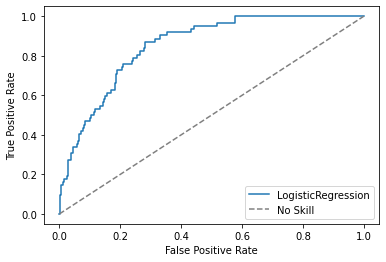

In [34]:
base_model=LogisticRegression().fit(X_train, y_train)

print('ROC_train',roc_auc_score(y_train,base_model.predict_proba(X_train)[:,1] ),
        'ROC_test',roc_auc_score(y_test,base_model.predict_proba(X_test)[:,1] ))

plt.figure()  
fpr, tpr, threshold=roc_curve(y_test, base_model.predict_proba(X_test)[:,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'--',color='grey')

plt.legend(['LogisticRegression','No Skill'])
plt.show()

At first glance this looks good, the score on the test set is 0.851831317204301 which for a balanced dataset would indicate a effective model. But what happens when we check f1 score and confusion matrix? 

In [35]:
print('f1_train',f1_score(y_train,base_model.predict(X_train) ),
        'f1_test',f1_score(y_test,base_model.predict(X_test) ))

f1_train 0.010638297872340425 f1_test 0.0


<Figure size 432x288 with 0 Axes>

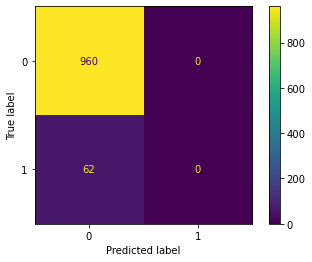

In [36]:
plt.figure()
matrix=confusion_matrix(y_test, base_model.predict(X_test),labels=base_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels=base_model.classes_)
disp.plot()
plt.show()

Now we see that the picture is completely different, the model is classifying all the test data into the negative class and therefore getting an f1 score of zero. Does this mean the model is valueless? Well no, f1 score is dependent on the thresholds for classification so if we vary this we can see:  

Max f1 value: 0.3352601156069364 at threshold: 0.13


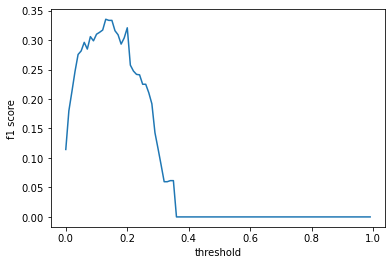

In [37]:
f1_values=[]
threshold_values=[x/100 for x in range(100)]
for threshold in threshold_values:
    y_predict=(base_model.predict_proba(X_test)[:, 1]>=threshold).astype(int)   
    f1_values.append(f1_score(y_test,y_predict))
        
print(f'Max f1 value: {max(f1_values)} at threshold: {f1_values.index(max(f1_values))/100}')
plt.figure()
plt.xlabel('threshold')
plt.ylabel('f1 score')
plt.plot(threshold_values,f1_values)
plt.show()

The model does have some value as a classifier, although clearly not with the default threshold. In contrast to the ROC_AUC score, the f1 score of 0.335 may seem particularly low compared to what we would expect on a balanced dataset but this is largely due to the imbalance. To more clearly illustrate the problem here, let's plot the confusion matrix for the threshold that maximises f1 score. 

<Figure size 432x288 with 0 Axes>

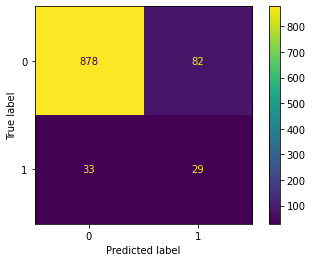

 True positive rate (recall) 0.46774193548387094
 False positive rate 0.08541666666666667
 Precision 0.26126126126126126


In [38]:
plt.figure()
y_predict=(base_model.predict_proba(X_test)[:, 1]>=0.13).astype(int)
matrix=confusion_matrix(y_test, y_predict,labels=base_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels=base_model.classes_)
disp.plot()
plt.show()

#print True positive rate, False positive rate, and Precision
fpr, tpr, threshold=roc_curve(y_test, y_predict)
print(f' True positive rate (recall) {tpr[1]}')
print(f' False positive rate {fpr[1]}')
print(f' Precision {precision_score(y_test,y_predict)}')

We can see that this model is preforming much better, but the despite the recall being acceptable and the false positive rate being quite good the precision is poor. This is a result of the class imbalance as even though a small proportion of the negative class is miss-classified, it is large enough that false positives represent the majority of positive predictions. 

To account for this issue, it is useful for us to use the precision-recall curve during our model evaluation.

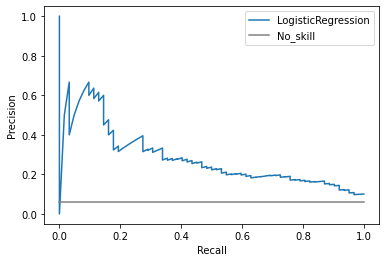

In [39]:
no_skill=y_test.mean()

plt.figure()
precision, recall, _ = precision_recall_curve(y_test,base_model.predict_proba(X_test)[:, 1])
plt.plot(recall,precision)
    
plt.plot([0,1],[no_skill,no_skill],label='No Skill', color='grey')
plt.legend(['LogisticRegression','No_skill'])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

This gives a somewhat more realistic impression of our model's performance than the ROC curve. 

## Building pipelines and tuning models  

I plan to compare logistic regression, tree ensembles, and neural networks so my first step is to create pipelines for these. The make_model function allows be to use the Sklearn KerasClassifier for my neural networks. 

In [40]:
#function to create neural networks to tune in GridSearchCV 
def make_model(layers, nodes, drop_rate):
    NN_model=tf.keras.models.Sequential()
    NN_model.add(tf.keras.layers.Input(shape=(20,)))
    for i in range(layers):
        NN_model.add(tf.keras.layers.Dense(nodes, activation='relu'))
        NN_model.add(tf.keras.layers.Dropout(drop_rate))
    
    NN_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))          
   
    NN_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                 loss=tf.keras.losses.BinaryCrossentropy(),
                 metrics=['AUC'])
    return NN_model

In [41]:
pipelines={'nn':make_pipeline(KerasClassifier(model=make_model)),
           'lr':make_pipeline(LogisticRegression()),
           'xgb': make_pipeline(XGBClassifier()),
          'rf':make_pipeline(RandomForestClassifier())}

In [42]:
#grid commented out for faster run time
lr_params={'logisticregression__random_state':[0],
          'logisticregression__max_iter':[1000],
          'logisticregression__penalty':['l2'],#['l1','l2'],
          'logisticregression__C': [0.1],#[0.01, 0.1, 1, 10, 100],
          'logisticregression__solver':['liblinear']}

xgb_params={'xgbclassifier__eta':[0.1],# [0.1,0.2],
           'xgbclassifier__max_depth':[4],#[4,5,6],
           'xgbclassifier__min_child_weight':[1],#[1,5],
           'xgbclassifier__reg_lambda':[1],#[1,5,10],
           'xgbclassifier__reg_alpha':[10],#[0,5,10],
           'xgbclassifier__scale_pos_weight':[20.860962566844922]}

rf_params={'randomforestclassifier__n_estimators':[100],#[100,200],
           'randomforestclassifier__max_depth':[6],#[4,5,6],
           'randomforestclassifier__min_samples_split':[2],#[2,5,10],
           'randomforestclassifier__min_samples_leaf':[1],#[1,5],
          'randomforestclassifier__random_state':[0]}

nn_params={'kerasclassifier__model__layers':[2],#[1,2,3],
          'kerasclassifier__model__nodes':[100],#[10,50,100],
          'kerasclassifier__model__drop_rate':[0.1],#[0,0.1,0.2],
          'kerasclassifier__epochs':[20],
          'kerasclassifier__verbose':[0]}


param_grid={'lr':lr_params,'xgb':xgb_params,'rf':rf_params,'nn':nn_params}

Now that the pipelines are set up it is time to run GridSearchCV, note that the scoring I have selected is average_precision, which summarises the precision recall curve. For more details on this scoring see: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html

In [43]:
tuned_models={}
for name, classifier in pipelines.items(): 
    print(f'fitting {name}')
    tuned_model=GridSearchCV(classifier, param_grid=param_grid[name],scoring='average_precision')
    tuned_model.fit(X_train,y_train)
    tuned_models[name]=tuned_model
    
    print('ROC_train',roc_auc_score(y_train,tuned_model.predict_proba(X_train)[:,1] ),
          'ROC_test',roc_auc_score(y_test,tuned_model.predict_proba(X_test)[:,1] ))
    
    print('f1_train',f1_score(y_train,tuned_model.predict(X_train) ),
          'f1_test',f1_score(y_test,tuned_model.predict(X_test) ))
    
    #print(tuned_model.best_params_)

fitting nn
ROC_train 0.858677399323086 ROC_test 0.8436323924731183
f1_train 0.0 f1_test 0.0
fitting lr
ROC_train 0.8455078705994761 ROC_test 0.8525873655913978
f1_train 0.0 f1_test 0.0
fitting xgb
ROC_train 0.9652461250166213 ROC_test 0.8326444892473117
f1_train 0.36616915422885576 f1_test 0.2835820895522388
fitting rf
ROC_train 0.9315916527642027 ROC_test 0.8533098118279571
f1_train 0.0418848167539267 f1_test 0.0


Looking only at ROC suggest our models are reasonably similar with perhaps XGB and RF overfitting somewhat. In contrast, f1 score suggests only XGBoost has any value as a classifier. As we discussed earlier, these metrics don't give a full picture for us to evaluate the models so let's plot the ROC and Precision-Recall curve. 

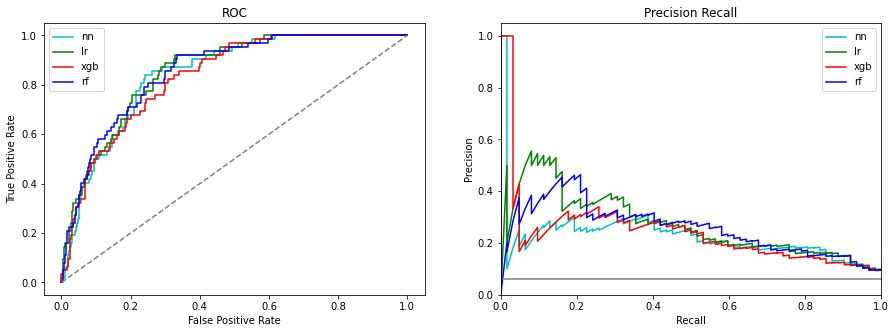

In [44]:
no_skill=y_test.mean()
colors={'rf':'b','xgb':'r','lr':'g', 'nn':'c'}
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5)) 
for name, classifier in tuned_models.items():
    y_predict=classifier.predict_proba(X_test)[:, 1]
    fpr, tpr, threshold=roc_curve(y_test, y_predict)
    
    ax1.plot(fpr, tpr,colors[name])
    
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')
ax1.set_title('ROC')
ax1.legend(tuned_models.keys())
ax1.plot([0, 1], [0, 1],'--',color='grey')

ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])

for name, classifier in tuned_models.items():
    precision, recall, _ = precision_recall_curve(y_test,classifier.predict_proba(X_test)[:, 1])
    ax2.plot(recall,precision,color=colors[name])
    
ax2.plot([0,1],[no_skill,no_skill],label='No Skill', color='grey')
ax2.legend(tuned_models.keys())
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision Recall')
plt.show()




plt.show()

As expected, the Precision-Recall gives a much less optimistic picture than the ROC but what is interesting is how similar each of our models performs, which does surprise me a little considering how different each of these machine learning approaches are. It is apparent that XGBoost is slightly under performing compared to the other classifiers, which I suspect is a result of the over fitting observed earlier. To obtain a more complete look at these models let us look at their confusion matrices.  

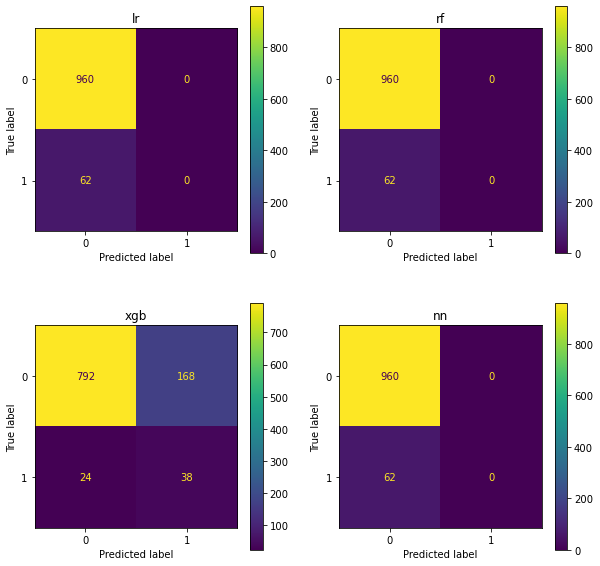

In [45]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10)) 
axes={'lr': ax1,'rf': ax2,'xgb': ax3, 'nn': ax4}
for name, classifier in tuned_models.items():
    matrix=confusion_matrix(y_test, classifier.predict(X_test),labels=classifier.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels=classifier.classes_)
    disp.plot(ax=axes[name])
    axes[name].set_title(name)
plt.show()


We see exactly the same issue observed before, the default thresholds are leading to 3 of the models only predicting the negative class. By graphing the f1 score against the threshold we can select the threshold that optimises it:

nn:Max f1 value: 0.3315508021390374 at threshold: 0.11
lr:Max f1 value: 0.3448275862068965 at threshold: 0.18
xgb:Max f1 value: 0.3389830508474576 at threshold: 0.66
rf:Max f1 value: 0.3604651162790698 at threshold: 0.12


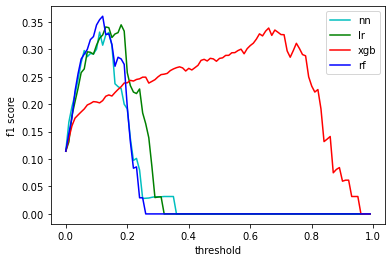

In [46]:
colors={'rf':'b','xgb':'r','lr':'g', 'nn':'c'}
optimal_thresholds={}
plt.figure()
for name, classifier in tuned_models.items():
    f1_values=[]
    threshold_values=[x/100 for x in range(100)]
    for threshold in threshold_values:
        y_predict=(tuned_models[name].predict_proba(X_test)[:, 1]>=threshold).astype(int)
        f1_values.append(f1_score(y_test,y_predict))
    
    optimal_thresholds[name]=f1_values.index(max(f1_values))/100
    print(f'{name}:Max f1 value: {max(f1_values)} at threshold: {f1_values.index(max(f1_values))/100}')
    
    plt.plot(threshold_values,f1_values, color=colors[name])
    
plt.xlabel('threshold')
plt.ylabel('f1 score')
plt.legend(tuned_models.keys())
plt.show()

Now let's look at the confusion matrices for these optimal thresholds 

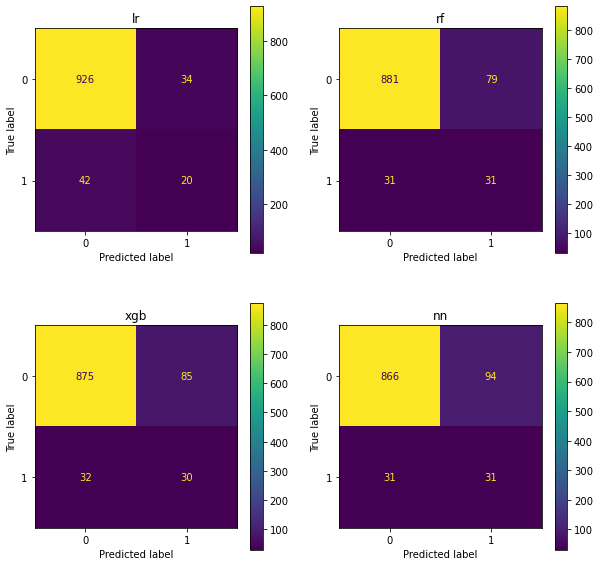

In [47]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10)) 
axes={'lr': ax1,'rf': ax2,'xgb': ax3, 'nn': ax4}
for name, classifier in tuned_models.items():
    y_predict=(classifier.predict_proba(X_test)[:, 1]>=optimal_thresholds[name]).astype(int)
    matrix=confusion_matrix(y_test, y_predict,labels=classifier.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels=classifier.classes_)
    disp.plot(ax=axes[name])
    axes[name].set_title(name)
plt.show()


Apart from logistic regression, each model is very similar (with random forest performing slightly better than the others). To actually determine which model is most suitable for a certain application would require setting a threshold to obtain the desired balance of precision and recall, we can see how confusion matices would be a useful tool once we have made this decision. 

# Conclusion

I hope this has been an informative look at model evaluation for imbalanced datasets. It has allowed me to develop my understanding of model evaluation, particularly some of the issues that can arise when insufficient care is taken. The key lesson I take from this project is, using evaluation metrics in isolation or in situations where they may not be suitable, can lead to overly optimistic impressions of model performance. To avoid this in the future, I will plan to use a range of techniques to evaluate my models, reducing any overreliance on a particular metric. 